# Customer Segmentation - 고객 군집

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# I. Import Packages and Google Drive Mount

> ## 1) Import Packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

> ## 2) Google Drive Mount
* 'Online_Retail.zip' 파일을 구글드라이브에 업로드 후 진행

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


* 마운트 결과 확인

In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/Online_Retail.zip'

-rw------- 1 root root 22824989 Mar  7 07:09 '/content/drive/My Drive/Colab Notebooks/datasets/Online_Retail.zip'


# II. Data Preprocessing

> ## 1) Unzip 'Online_Retail.zip'

* Colab 파일시스템에 'Online_Retail.csv' 파일 생성

In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/Online_Retail.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/Online_Retail.zip
  inflating: Online_Retail.xlsx      


* Online_Retail.zip 파일 확인

In [ ]:
!ls -l

total 23168
drwx------ 5 root root     4096 Mar 10 05:40 drive
-rw-r--r-- 1 root root 23715344 Mar  7 16:08 Online_Retail.xlsx
drwxr-xr-x 1 root root     4096 Mar  5 14:37 sample_data


> ## 2) 데이터 읽어오기

* pandas DataFrame

In [ ]:
%%time

DF = pd.read_excel('Online_Retail.xlsx')

DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
CPU times: user 38.5 s, sys: 392 ms, total: 38.9 s
Wall time: 38.9 s


> ## 3) 데이터 설명

* InvoiceNo : 주문 번호, 'C' 시작은 주문취소
* StockCode : 제품 코드(Item Code)
* Description : 제품 설명
* Quantity : 주문 건수
* InvoiceDate : 주문 날짜
* UnitPrice : 제품 단가
* CustomerID : 고객번호
* Country : 국가명(주문 고객 국적)

In [ ]:
DF.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


> ## 4) 결측치 제거

* 'Quantity', 'UnitPrice', 'CustomerID'

In [ ]:
DF = DF[DF['Quantity'] > 0]
DF = DF[DF['UnitPrice'] > 0]
DF = DF[DF['CustomerID'].notnull()]

DF.shape

(397884, 8)

* 결과 확인

In [ ]:
DF.isnull().sum(axis = 0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

> ## 5) 'United Kingdom' 만 사용

* 대부분의 구매자가 영국국적

In [ ]:
DF['Country'].value_counts()[:10]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: Country, dtype: int64

* 영국 데이터만 추출

In [ ]:
DF = DF[DF['Country'] == 'United Kingdom']

DF.shape

(354321, 8)

# III. RMF 기반 Data Reengineering

* RECENCY : 가장 최근 상품 구매일에서 오늘까지 기간
* FREQUENCY : 삼품 구매 횟수
* MONETARY VALUE : 총 구매 금액

> ## 1) 'sale_amount' 추가

* '주문 금액' = '주문 개수' * '제품 가격'

In [ ]:
DF['sale_amount'] = DF['Quantity'] * DF['UnitPrice']

In [ ]:
DF.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


* 'Customer ID' 정수 변환

In [ ]:
DF['CustomerID'] = DF['CustomerID'].astype(int)

> ## 2) 주문 특성 확인

* Top-5 주문 건수 'Customer ID'

In [ ]:
DF['CustomerID'].value_counts().head(5)

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64

* Top-5 주문 금액 'Customer ID'

In [ ]:
DF.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending = False)[:5]

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64

* 몇몇 특정 고객이 많은 '주문 건수'와 '주문 금액'을 가지고 있음

> ## 3) 'Customer ID' 기준으로 DataFrame 재구성

* Recency : 'InvoiceDate'의 max()
* Frequency : 'InvoiceNo'의 count()
* Monetary value : 'sale_amount'의 sum()

In [ ]:
aggregations = {'InvoiceDate': 'max',
                'InvoiceNo': 'count',
                'sale_amount':'sum'}

DF_CID = DF.groupby('CustomerID').agg(aggregations)

* groupby( ) 결과 Index와 Column 이름 수정
 - 'Recency', 'Frequency', 'Monetary'

In [ ]:
DF_CID = DF_CID.rename(columns = {'InvoiceDate':'Recency',
                                  'InvoiceNo':'Frequency',
                                  'sale_amount':'Monetary'
                                   })

DF_CID = DF_CID.reset_index()

* RMF 변경 결과

In [ ]:
DF_CID.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73
3,12749,2011-12-06 09:56:00,199,4090.88
4,12820,2011-12-06 15:12:00,59,942.34


> ## 4) 최근 구매일자 Day로 변경

* 오늘 날짜에서 최근 구매날짜('Recency')를 뺀 일자

In [ ]:
import datetime as dt

DF_CID['Recency'] = dt.datetime(2011, 12, 10) - DF_CID['Recency']
DF_CID['Recency'] = DF_CID['Recency'].apply(lambda x: x.days + 1)

* 처리 결과 확인

In [ ]:
DF_CID.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34


> ## 5) Visualization

* 변수 별 분포 확인

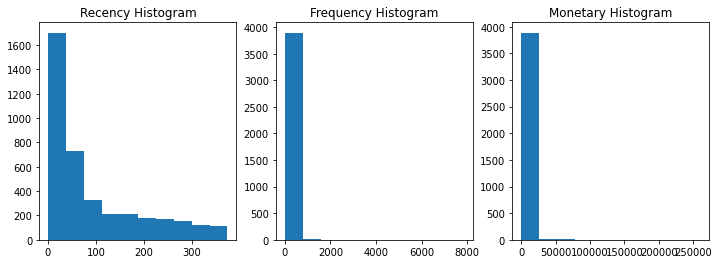

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 4), nrows = 1, ncols = 3)

ax1.set_title('Recency Histogram')
ax1.hist(DF_CID['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(DF_CID['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(DF_CID['Monetary'])

plt.show()

# IV. K-means Clustering

> ## 1) Standardization

* 표준화를 통한 평균과 표준편차 Scaling

In [ ]:
DF_CID[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


* Scaling 수행

In [ ]:
from sklearn.preprocessing import StandardScaler

X_input = DF_CID[['Recency','Frequency','Monetary']].values
X_input_scaled = StandardScaler().fit_transform(X_input)

> ## 2) Modeling

* K-means

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5,
                random_state = 2045)

kmeans.fit_predict(X_input_scaled)

array([1, 0, 4, ..., 0, 0, 0], dtype=int32)

> ## 3) Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_score(X_input_scaled, kmeans.fit_predict(X_input_scaled))

0.6114742734112578

# 
# 
# 
# The End
# 
# 
# 